# Feature based Light Curve Classification
**Written by:** Christopher Wells (SUNY Oswego), Ashish Mahabal (Caltech)


**Dependencies:**
- numpy (1.11.1)
- pandas (0.20.3)
- matplotlib (2.0.2)
- seaborn (0.8)

We will use data on periodic variables from CRTS (https://arxiv.org/abs/1405.4290)
There are ~50,000 objects, in ~17 classes. We will learn about Light Curves (== Time Series), and one way of classifying them - using features. (Accompanying slides).

In this notebook we will use a subset of that dataset with only a few classes, and only a few features. You should use the bigger dataset, and more features.

First let's load in the catalog data. The catalog contains the ids for the light curves and a few different classes of periodic variable.

In [1]:
import pandas as pd

catalog_file = "catalog.csv"
data = pd.read_csv(catalog_file)

data

,id,category
0,1132001045263,beta Lyrae
1,1012001026394,RRab
2,1143001058200,RRab
3,1018001037204,RRab
4,1012002050063,beta Lyrae
5,1143001077142,RRab
6,1126001058284,EA_UP
7,1009002011733,RRab
8,1012002037935,RRab
9,1018002043699,RRab


Let us load some individual light curves.

Light curves from photometric astronomical surveys should have at least two peices of information for each observation: a time stamp when the observation occured, and the measured magnitude. Optionally - in fact ideally - there should also be an error associated with the measurement. We do have measurement errors.

The light curves are in csv files which we now store in numpy arrays.

In [3]:
import os

curves_dir = "curves/"
curve_ids = data["id"]

light_curves = []
for c_id in curve_ids:
    curve_file = os.path.join(curves_dir, str(c_id) + ".csv")
    
    curve_frame = pd.read_csv(curve_file)
    curve = curve_frame.as_matrix(["time", "mag", "magerr"])
    
    light_curves.append(curve)

We will now plot a few of these light curves to see how they look

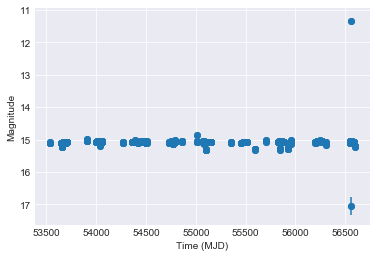

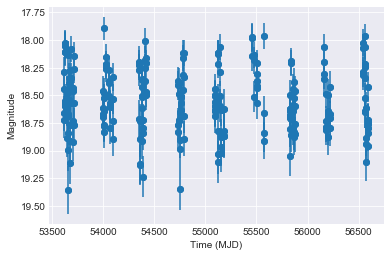

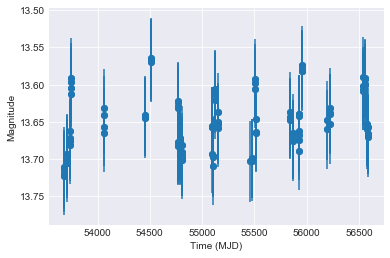

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

for curve in light_curves[0:3]:
    times = curve[:,0]
    magnitudes = curve[:,1]
    errors = curve[:,2]

    plt.scatter(times, magnitudes)
    plt.errorbar(times, magnitudes, yerr = errors, fmt='o')
    plt.xlabel("Time (MJD)")
    plt.ylabel("Magnitude")
    plt.gca().invert_yaxis()        # numerically small magnitudes indicate brighter objects
    plt.show()

Notice that you can not directly comepare these light curves. (Why?)

There is a huge variety in the features e.g. some are defined directly on the time series, some on interpolated time series, some on a residual after the fit.

Richards et al. (2011) had used many elementary features on non-sparse Ogle data and many of them continue to be used for sparse sets too.

Here are two sites that have details for many features including soem specialized one:
Caltech Time Series Characterization Service (CTSCC): http://nirgun.caltech.edu:8000/scripts/description.html
Feature Analysis for Time Series (FATS): http://isadoranun.github.io/tsfeat/FeaturesDocumentation.html

We now define a few features.


In [6]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

def amplitude(magnitudes):
    return 0.5 * (np.max(magnitudes) - np.min(magnitudes))

def median_absolute_deviation(magnitudes):
    median = np.median(magnitudes)
    deviations = magnitudes - median
    absolute_deviations = np.absolute(deviations)

    return np.median(absolute_deviations)

def residual_bright_faint_ratio(magnitudes):    # median as a fit
    mean = np.mean(magnitudes)

    brighter = magnitudes[magnitudes > mean]
    fainter = magnitudes[magnitudes < mean]

    resid_brighter = np.mean(np.square(brighter - mean))
    resid_fainter = np.mean(np.square(fainter - mean))

    ratio = resid_fainter / resid_brighter

    return ratio

def welch_stetson_K(magnitudes, errors):
    num_obs = magnitudes.shape[0]

    mean_mag = np.mean(magnitudes)

    a = np.sqrt(num_obs / (num_obs - 1)) * ((magnitudes - mean_mag) / errors)

    b = np.mean(np.absolute(a))
    c = np.sqrt(np.mean(np.square(a)))

    stetson_K = b / c

    return stetson_K

def gaussian_process_regression(times, magnitudes, errors):
    times_X = np.expand_dims(times, 1)
    
    gauss = GaussianProcessRegressor(alpha=1)
    gauss.fit(times_X, magnitudes)
    
    prior_mean = np.median(magnitudes)
    
    min_time = np.min(times)
    max_time = np.max(times)
    interval = (max_time - min_time) / 100.0
    
    gauss_times = np.arange(min_time, max_time, interval)
    gauss_times_X = np.expand_dims(gauss_times, 1)
    
    gauss_mags = gauss.sample_y(gauss_times_X) + prior_mean
    
    return gauss_times, gauss_mags

def total_variation(gauss_mags):
    m = gauss_mags.size

    mags_m_plus_1 = gauss_mags[1:]
    mags_m = gauss_mags[0:-1]

    abs_diffs = np.absolute(mags_m_plus_1 - mags_m)

    return np.sum(abs_diffs) / m

Now that we have a few light curve features defined, we can compute them for each of the light curves in our catalog.

In [7]:
def get_features(curve):
    times = curve[:,0]
    magnitudes = curve[:,1]
    errors = curve[:,2]
    
    ampl = amplitude(magnitudes)
    mad = median_absolute_deviation(magnitudes)
    br_fa = residual_bright_faint_ratio(magnitudes)
    stet_K = welch_stetson_K(magnitudes, errors)
    
    gauss_times, gauss_mags = gaussian_process_regression(times, magnitudes, errors)
    totvar = total_variation(gauss_mags)
    
    famp = amplitude(gauss_mags)
    
    feats = {
        "ampl": ampl,
        "mad": mad,
        "br_fa": br_fa,
        "stet_K": stet_K,
        "totvar": totvar,
        "famp": famp
    }
    
    return feats

features = [get_features(curve) for curve in light_curves]

Let us look at the calculated features, again for the first three light-curves.

In [8]:
#from __future__ import print_function

for (c_id, feats) in zip(curve_ids[0:3], features[0:3]):
    print(c_id)
    
    for f in feats:
        print(f, ": ", feats[f])
        
    print("")
    
print("...")

1132001045263
ampl :  2.8488285
mad :  0.014893
br_fa :  1.53739380263
stet_K :  0.325149609264
totvar :  2.18512295958
famp :  7.09384385693

1012001026394
ampl :  0.7317015
mad :  0.205786
br_fa :  1.13801205188
stet_K :  0.808286378242
totvar :  2.62619629916
famp :  8.55422471977

1143001058200
ampl :  0.0793785
mad :  0.024936
br_fa :  1.57725439268
stet_K :  0.821861213073
totvar :  1.25299485793
famp :  6.53131721196

...


Now that we have the features calculated, let us combine them with the catalog information.

In [9]:
data_feat = pd.DataFrame(features)
data_feat["id"] = curve_ids

data_feat = data_feat.merge(data, on="id")

data_feat

,ampl,br_fa,famp,mad,stet_K,totvar,id,category
0,2.848828,1.537394,7.093844,0.014893,0.325150,2.185123,1132001045263,beta Lyrae
1,0.731702,1.138012,8.554225,0.205786,0.808286,2.626196,1012001026394,RRab
2,0.079379,1.577254,6.531317,0.024936,0.821861,1.252995,1143001058200,RRab
3,1.485876,0.789104,8.864455,0.365766,0.737108,2.424899,1018001037204,RRab
4,0.300673,0.230666,7.284239,0.055182,0.768989,2.147134,1012002050063,beta Lyrae
5,1.113359,1.176916,8.093571,0.206672,0.806348,1.316876,1143001077142,RRab
6,0.364004,0.066938,7.439895,0.027766,0.611048,1.896632,1126001058284,EA_UP
7,0.792099,1.093868,8.195112,0.206261,0.791534,2.142767,1009002011733,RRab
8,0.656046,1.124566,8.231025,0.173738,0.790750,2.606791,1012002037935,RRab
9,0.634423,3.014010,7.697300,0.180788,0.824355,2.211113,1018002043699,RRab


Now let's take a look at how well the light curve features we have calculated seperate the different categories.

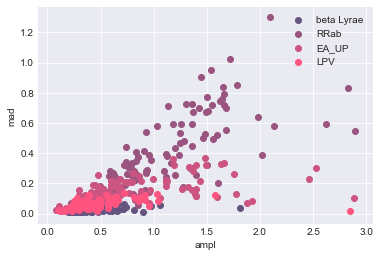

In [10]:
x_col = "ampl"
y_col = "mad"

n = 1
for (category, row) in data_feat.groupby(by="category"):
    n = n + 1
    plt.scatter(row[x_col], row[y_col], color = (n*0.2,0.33,0.5, 1))

plt.legend(data_feat["category"].unique())
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.show()

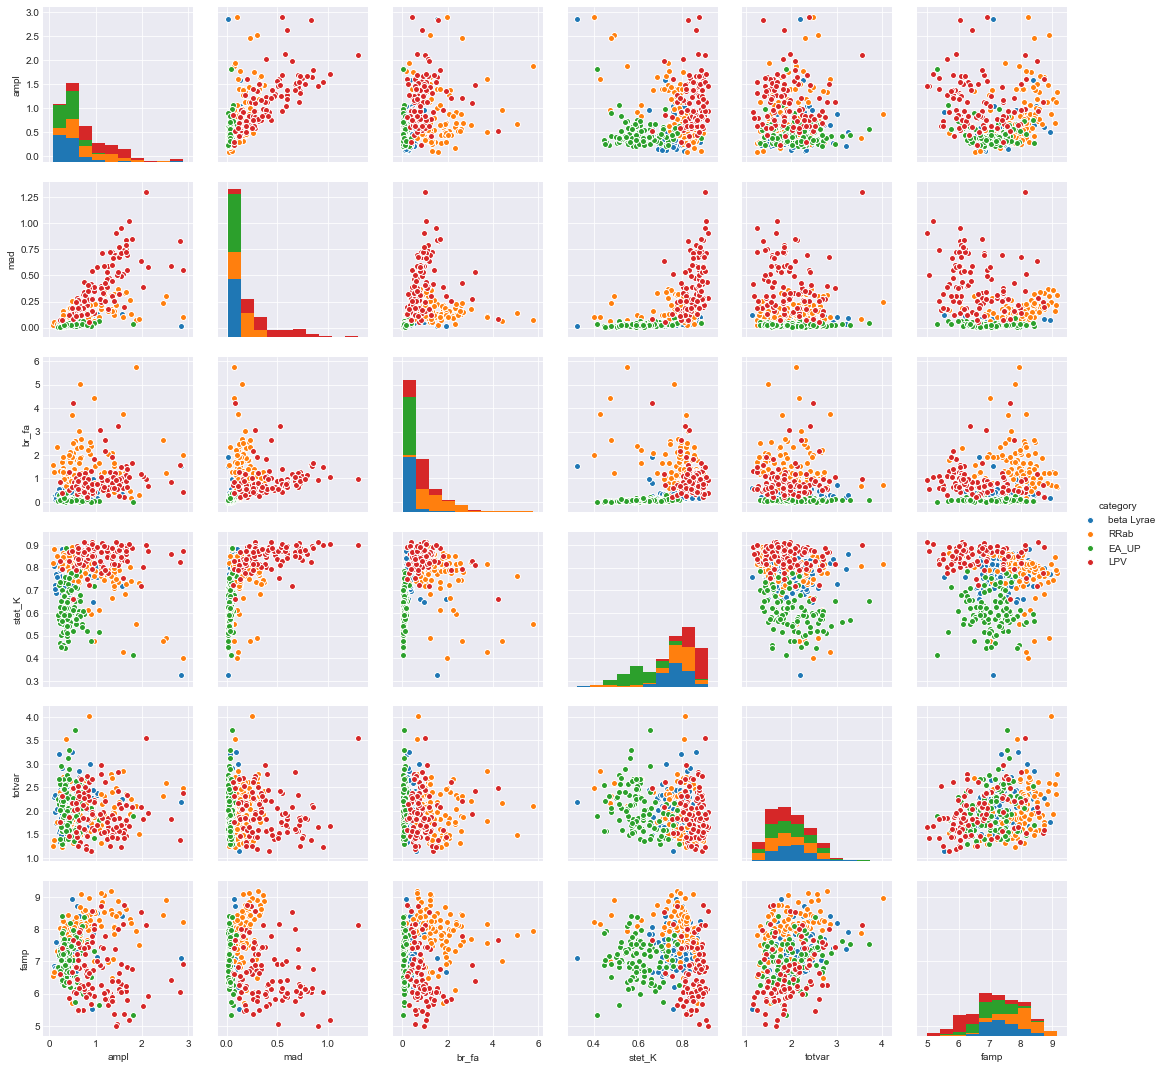

In [11]:
cols = ["ampl", "mad", "br_fa", "stet_K", "totvar", "famp", "category"]

sns.pairplot(data_feat[cols], hue="category")
plt.show()

## Classification

Now that we have a few features extracted from each of the light curves, let's try creating a few classifiers for different categories.

To keep it simple, let's just look at ``RRab`` and ``LPV`` for now.

### What is an RR Lyrae type variable star?
### What is an LPV?

In [12]:
classes = ["RRab", "LPV"]

data_class = data_feat[data_feat["category"].isin(classes)]

Let's take the features we have on the ``RRab`` and ``LPV`` and create a ``RandomForestClassifier`` to classify future unlabeled light curves between the two groups.

In [13]:
from sklearn.ensemble import RandomForestClassifier

X_cols = ["ampl", "mad", "br_fa", "stet_K", "totvar", "famp"]

X_rf = data_class.as_matrix(X_cols)
y_rf = np.array(data_class["category"])

rf = RandomForestClassifier(random_state=42)

rf.fit(X_rf, y_rf)
rf.score(X_rf, y_rf)

0.98999999999999999

So we were able to create a classifier that can accurately distinguish between the two groups ``98.99%`` of the time in the training data.

We will likely not get this level of performance on new unlabeled data, but we can at least see that the classifier is able to distinguish between the groups using the features we have extracted.

To get a better idea of the performance we can get the mean score across several cross validations, or several different train test splits.

In [14]:
from sklearn.model_selection import cross_val_score

rf_cv = RandomForestClassifier(random_state=42)

cv_scores_rf = cross_val_score(rf_cv, X_rf, y_rf, cv=5)

print("Mean Score:\t\t", np.mean(cv_scores_rf))
print("Standard Deviation:\t", np.std(cv_scores_rf))

Mean Score:		 0.9
Standard Deviation:	 0.0524404424085


We can also try creating some other types of classifiers other than just random forests.

Let's try training a ``SupportVectorClassifier`` on the data.

In [15]:
from sklearn.svm import SVC

X_svc = data_class.as_matrix(X_cols)
y_svc = np.array(data_class["category"])

svc_cv = SVC(random_state=42)

cv_scores_svc = cross_val_score(svc_cv, X_svc, y_svc, cv=5)

print("Mean Score:\t\t", np.mean(cv_scores_svc))
print("Standard Deviation:\t", np.std(cv_scores_svc))

Mean Score:		 0.885
Standard Deviation:	 0.0663324958071


Here we can see that the random forest classifier is classifying the data slightly better than the support vector classifier.

Though perhaps the support vector classifier could achieve better results if we pre-process the data a bit.

### What is unbalanced data? Why it can be bad?
### What would (some) pre-processing be?

## Dimensionality Reduction

When we extract a bunch of features from light curves, we will end up with data that has many different dimensions (one dimension per feature).

When dealing with high dimensional data you can run into issues with the curse of dimensionality. This means that high dimensional data can be difficult to work with as it is:
- Difficult for humans to interpret
- Difficult to train some types of classifiers on
- Difficult to apply traditional distance metrics to (such as Euclidean distance)
- Requires more space to store
- Requires more time to run

We can apply dimensionality reduction techiniques like principle component analysis to compress the data we have into a smaller number of features.

In exchange for a small loss of information, we can reduce the number of features we are working with to help resolve issues with the curse of dimensionality.

In [16]:
from sklearn.decomposition import PCA

num_previous_features = len(X_cols)
num_new_features = num_previous_features - 2

X_pca = data_feat.as_matrix(X_cols)

pca = PCA(num_new_features)

pca.fit(X_pca)

X_transformed = pca.transform(X_pca)

print("= Shape =")
print("Before:\t", X_pca.shape)
print("After:\t", X_transformed.shape, "\n")

print("= Size =")
print("Before:\t", X_pca.size)
print("After:\t", X_transformed.size)

= Shape =
Before:	 (400, 6)
After:	 (400, 4) 

= Size =
Before:	 2400
After:	 1600


In addition to reducting the amount of data to be processed, dimensionality reduction techniques can also help to make data easier to interpret.

To see this let's try applying t-SNE with 2 components to the data and plot the resulting data by category in a scatter plot.

In [17]:
X_pca.max()

9.1704511756622509

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(2, random_state=42)

X_tsne = tsne.fit_transform(X_pca)

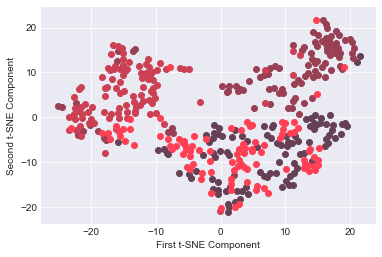

In [19]:
data_tsne = pd.DataFrame(X_tsne)
data_tsne["category"] = data_feat["category"]

n = 1
for (category, row) in data_tsne.groupby(by="category"):
    n = n + 1
    plt.scatter(row[0], row[1], color = (n*0.2, 0.25, 0.33, 1))

#plt.legend(data_tsne["category"].unique())
plt.xlabel("First t-SNE Component")
plt.ylabel("Second t-SNE Component")
plt.show()

Here we can see that each of the categories are fairly seperable from one another with the exception of the ``beta Lyrae`` and ``LPV``.

Indeed if we were to train and test a classifier on the data we would find that these two classes would be fairly often confused with one another if we use just these features. Perhaps some new ones could resolve this issue.

Applying techniques like t-SNE can allow us to get an idea of what level of classification performance we can expect to get on the data before we even train or test any classifiers. It is a kind of clustering, an unsupervized method which will be covered separately. If we ignore the category labels in the plot we would be able to see at least 3 clusters in the data without having to look into any of the extracted features. 

A few references:
Cody: https://arxiv.org/abs/1401.6582 
Drake: https://arxiv.org/abs/1405.4290 
Faraway: https://arxiv.org/abs/1401.3211 
Graham: https://arxiv.org/abs/1306.6664 
Mahabal: https://arxiv.org/abs/0802.3199 
Richards:https://arxiv.org/abs/1101.1959
And many many more ...